In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor as MOR
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV, RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
import xgboost as xgb
import warnings
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering,\
FeatureAgglomeration, Birch, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

In [3]:
path = 'filled.xlsx'

df = pd.read_excel(path)

In [14]:
# Bokeh libraries
from bokeh.io import output_file, output_notebook, save
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Legend, BasicTicker, ColorBar, HoverTool, LinearColorMapper, PrintfTickFormatter, FactorRange
from bokeh.layouts import row, column, gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter
from bokeh.models.widgets import Tabs, Panel
from bokeh.palettes import Viridis256, Category20
from bokeh.transform import transform
import matplotlib.cm as cm
import matplotlib as mpl

In [15]:
 def heatmap(title,df,correlation_method,width,height):

    # generate a pearson correaltion dataframe
    corr = df.corr(method=correlation_method)
    
    # reshape the correlation dataframe
    corr_re = pd.DataFrame({'correlation':corr.stack(),
                            'pairs':[[x,y] for x in df.columns.to_list() for y in df.columns.to_list()]}).reset_index()
    
    #generate a source for Bokeh
    source = ColumnDataSource(corr_re)
    
    mapper = LinearColorMapper(palette=Viridis256, low=corr_re.correlation.min(), high=corr_re.correlation.max())
    
    # define the tooltips
    tooltips = [('pairs', '@pairs'),
                ('correlation', '@correlation{0.3f}')]
    
    # extract the column names
    corr_columns = corr.columns.tolist()
    
    # generate the figure
    hm = figure(title=title, tooltips=tooltips, toolbar_location="above",
            x_range = corr_columns, y_range=corr_columns, plot_width=width, plot_height=height)
    
    hm.rect(x="level_0", y="level_1", width=1, height=1, source=source,
            line_color="black", line_alpha=0.3 ,fill_color=transform("correlation",mapper))
    
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=10))
    
    hm.add_layout(color_bar, 'right')
    hm.axis.axis_line_color = None
    hm.axis.major_tick_line_color = None
    hm.axis.major_label_text_font_size = "7pt"
    hm.axis.major_label_standoff = 0
    hm.xaxis.major_label_orientation = 1
    
    output_notebook()
    show(hm)
    
    return hm

In [16]:
df_dropped = df.dropna(subset=['GAS_C1', 'OIL_PRPH'])

In [4]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'FIELDNAME', 'FIELDAREA', 'ORGGRPNM', 'UNITNAME',
       'UNITTYPCOD', 'UNITTYPDES', 'LOCATION', 'PERIODDATE', 'PERIODYRMN',
       'PERIODMNTH', 'PERIODMNNM', 'PERIODYR', 'OILPRODMAS', 'OILPRODM3',
       'OILPRDDENS', 'OILPRODMBD', 'DGASPRODMA', 'DGASPROKSM', 'DGASPROMMS',
       'DGASPRODEN', 'AGASPRODMA', 'AGASPROMMS', 'AGASPROKSM', 'AGASPRODEN',
       'GCONDMASS', 'GCONDVOL', 'GCONDMBD', 'GCONDDEN', 'INJWATMASS',
       'INJWATVOL', 'INJWATMBD', 'WATPRODMAS', 'WATPRODVOL', 'WATPRODMBD',
       'WELLREGNO', 'GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4',
       'GAS_IC5', 'GAS_NC5', 'Target depth (m)', 'OIL_PRPH', 'OIL_PR17',
       'OIL_PH18', 'OIL_CPI', 'OIL_CPI_PH', 'OIL_CPI_SS', 'OIL_WAX', 'TOC',
       'REV_TOTS1', 'REV_TOTS2', 'REV_TOTS3', 'REV_TMAX', 'H_INDEX', 'O_INDEX',
       'P_INDEX'],
      dtype='object')

In [6]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.sample import morris as morris_sampler
from SALib.test_functions import Ishigami
from SALib.analyze import morris as morris_analyzer

In [7]:
X = df_dropped[['X', 'Y', 'GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5', 
       'OIL_PRPH', 'OIL_PR17','OIL_PH18', 'OIL_CPI', 'OIL_CPI_PH', 'OIL_CPI_SS', 'OIL_WAX']]
y = df_dropped['OILPRODMAS']

In [8]:
problem = {
    'num_vars': X.shape[1],
    'names': X.columns.to_list(),
    'bounds': np.concatenate((np.min(X, axis = 0)[:, None], np.max(X, axis = 0)[:, None]), axis = 1)
}

C:\Users\andrei.erofeev\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\andrei.erofeev\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:37:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


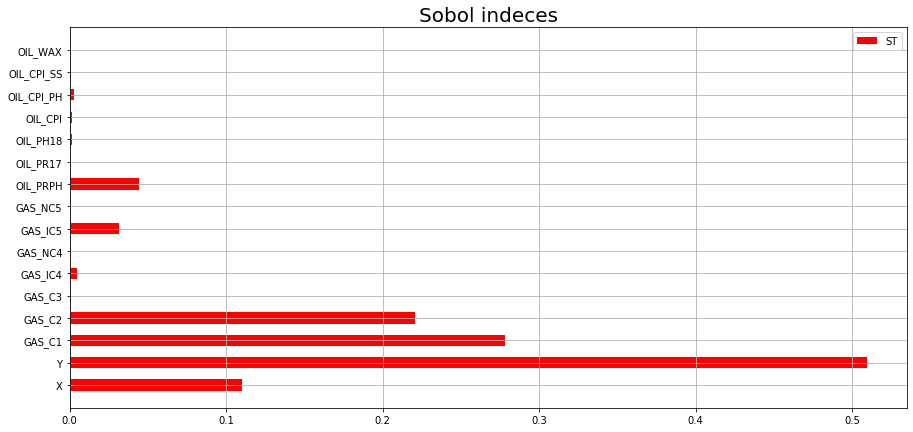

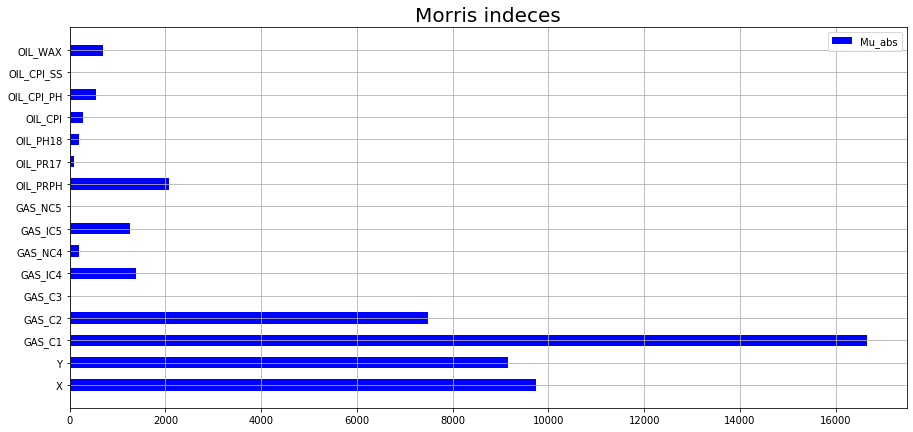

In [9]:
bar_width = 0.5
param_values = saltelli.sample(problem, 1000)
regr = xgb.XGBRegressor()
regr.fit(X.values, y)
Y_0 = regr.predict(param_values)
Si_0 = sobol.analyze(problem, Y_0)
plt.figure(figsize = (15, 7))
y_pos = np.arange(len(X.columns))
plt.barh(y_pos, Si_0["ST"], bar_width, color = 'r', label = "ST")
plt.yticks(y_pos, X.columns)
plt.title('Sobol indeces', fontsize = 20)
plt.legend()
plt.grid(True)
plt.savefig('sobol_gas_oil.png')
plt.show()

X_morris = morris_sampler.sample(problem, 1000)
Y_0 = regr.predict(X_morris)
Si_0 = morris_analyzer.analyze(problem, X_morris, np.float32(Y_0), conf_level=0.95, print_to_console=False)
plt.figure(figsize = (15, 7))
plt.barh(y_pos,  Si_0['mu_star'], bar_width, color = 'b', label = 'Mu_abs')
plt.yticks(y_pos, X.columns)
plt.title('Morris indeces', fontsize = 20)
plt.grid(True)
plt.legend()
plt.savefig('morris_gas_oil.png')
plt.show()

In [10]:
cross_val_score(xgb.XGBRegressor(n_estimators = 500), X, y, cv = 5).mean()

[09:38:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\andrei.erofeev\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\andrei.erofeev\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:38:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\andrei.erofeev\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\andrei.erofeev\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:38:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


-15.595315487649847

In [47]:
df_dropped = df.dropna(subset=['GAS_C1'])

In [48]:
X = df_dropped[['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']]
y = df_dropped['OILPRODMAS']

In [49]:
problem = {
    'num_vars': X.shape[1],
    'names': X.columns.to_list(),
    'bounds': np.concatenate((np.min(X, axis = 0)[:, None], np.max(X, axis = 0)[:, None]), axis = 1)
}

[03:14:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


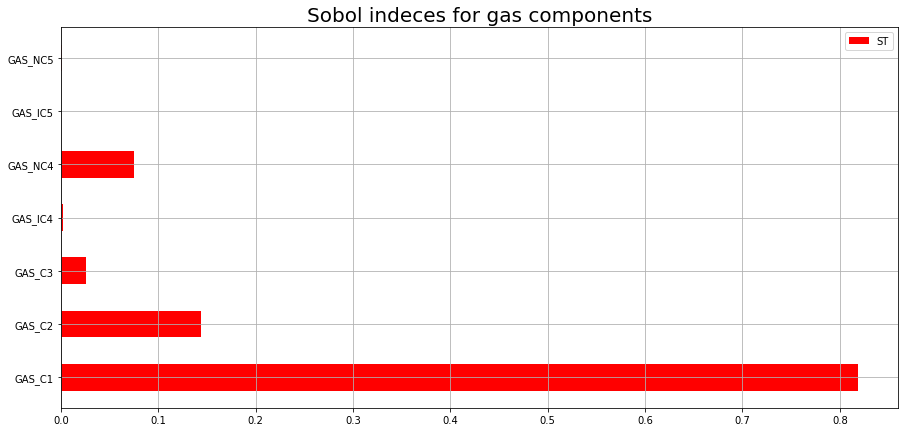

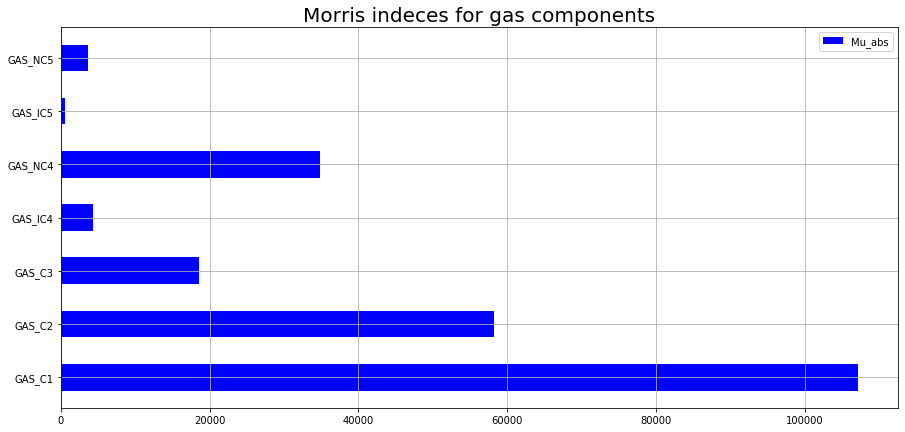

In [50]:
bar_width = 0.5
param_values = saltelli.sample(problem, 1000)
regr = xgb.XGBRegressor()
regr.fit(X.values, y)
Y_0 = regr.predict(param_values)
Si_0 = sobol.analyze(problem, Y_0)
plt.figure(figsize = (15, 7))
y_pos = np.arange(len(X.columns))
plt.barh(y_pos, Si_0["ST"], bar_width, color = 'r', label = "ST")
plt.yticks(y_pos, X.columns)
plt.title('Sobol indeces for gas components', fontsize = 20)
plt.legend()
plt.grid(True)
plt.savefig('sobol_gas.png')
plt.show()

X_morris = morris_sampler.sample(problem, 1000)
Y_0 = regr.predict(X_morris)
Si_0 = morris_analyzer.analyze(problem, X_morris, np.float32(Y_0), conf_level=0.95, print_to_console=False)
plt.figure(figsize = (15, 7))
plt.barh(y_pos,  Si_0['mu_star'], bar_width, color = 'b', label = 'Mu_abs')
plt.yticks(y_pos, X.columns)
plt.title('Morris indeces for gas components', fontsize = 20)
plt.grid(True)
plt.legend()
plt.savefig('morris_gas.png')
plt.show()

In [51]:
df_dropped = df.dropna(subset=['OIL_PRPH'])

In [52]:
X = df_dropped[['OIL_PRPH', 'OIL_PR17','OIL_PH18', 'OIL_CPI', 'OIL_CPI_PH', 'OIL_CPI_SS', 'OIL_WAX']]
y = df_dropped['OILPRODMAS']

In [53]:
problem = {
    'num_vars': X.shape[1],
    'names': X.columns.to_list(),
    'bounds': np.concatenate((np.min(X, axis = 0)[:, None], np.max(X, axis = 0)[:, None]), axis = 1)
}

[03:14:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


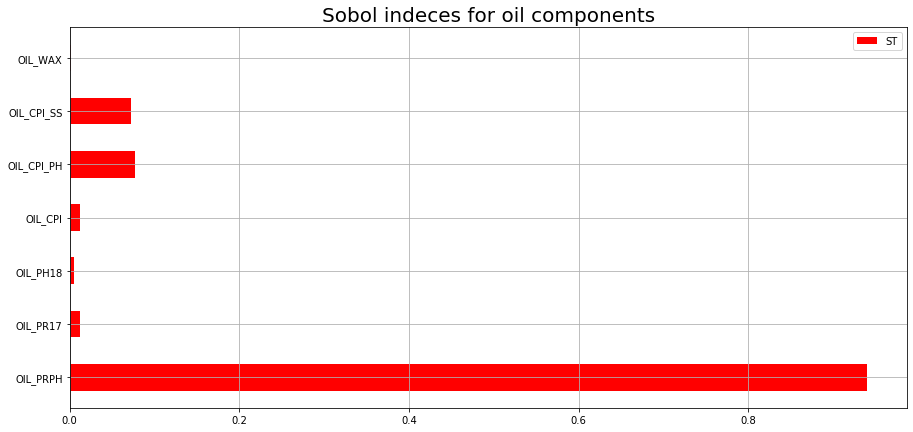

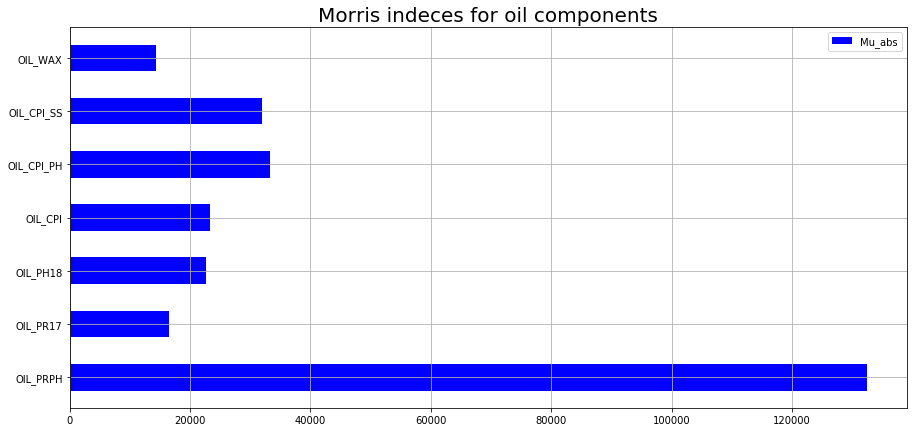

In [54]:
bar_width = 0.5
param_values = saltelli.sample(problem, 1000)
regr = xgb.XGBRegressor()
regr.fit(X.values, y)
Y_0 = regr.predict(param_values)
Si_0 = sobol.analyze(problem, Y_0)
plt.figure(figsize = (15, 7))
y_pos = np.arange(len(X.columns))
plt.barh(y_pos, Si_0["ST"], bar_width, color = 'r', label = "ST")
plt.yticks(y_pos, X.columns)
plt.title('Sobol indeces for oil components', fontsize = 20)
plt.legend()
plt.grid(True)
plt.savefig('sobol_oil.png')
plt.show()

X_morris = morris_sampler.sample(problem, 1000)
Y_0 = regr.predict(X_morris)
Si_0 = morris_analyzer.analyze(problem, X_morris, np.float32(Y_0), conf_level=0.95, print_to_console=False)
plt.figure(figsize = (15, 7))
plt.barh(y_pos,  Si_0['mu_star'], bar_width, color = 'b', label = 'Mu_abs')
plt.yticks(y_pos, X.columns)
plt.title('Morris indeces for oil components', fontsize = 20)
plt.grid(True)
plt.legend()
plt.savefig('morris_oil.png')
plt.show()

In [63]:
df_dropped = df.dropna(subset=['GAS_C1', 'TOC'])

In [64]:
X = df_dropped[['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5', 'TOC']]
y = df_dropped['OILPRODMAS']

In [65]:
problem = {
    'num_vars': X.shape[1],
    'names': X.columns.to_list(),
    'bounds': np.concatenate((np.min(X, axis = 0)[:, None], np.max(X, axis = 0)[:, None]), axis = 1)
}

[03:15:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


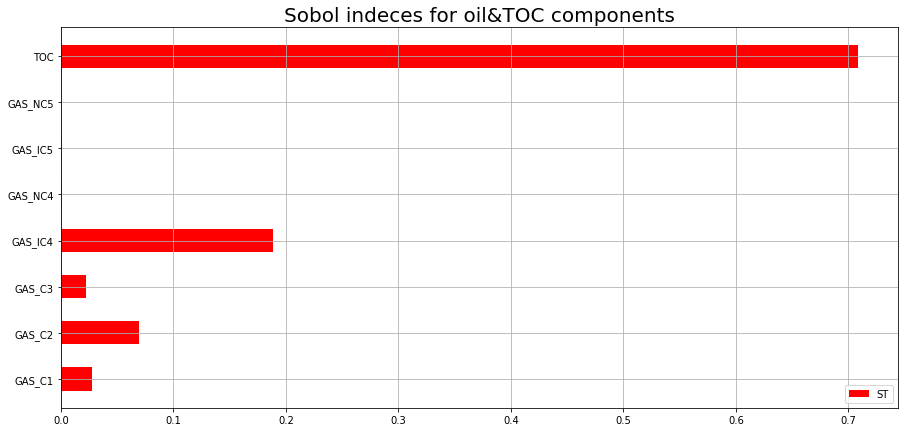

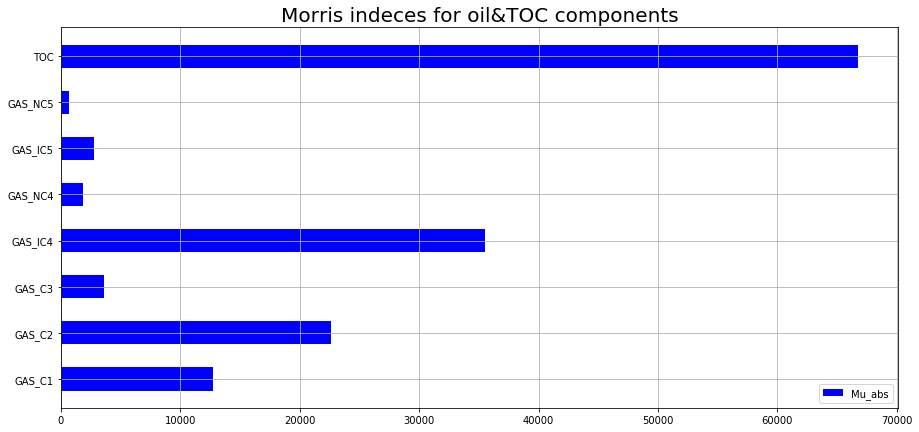

In [66]:
bar_width = 0.5
param_values = saltelli.sample(problem, 1000)
regr = xgb.XGBRegressor()
regr.fit(X.values, y)
Y_0 = regr.predict(param_values)
Si_0 = sobol.analyze(problem, Y_0)
plt.figure(figsize = (15, 7))
y_pos = np.arange(len(X.columns))
plt.barh(y_pos, Si_0["ST"], bar_width, color = 'r', label = "ST")
plt.yticks(y_pos, X.columns)
plt.title('Sobol indeces for oil&TOC components', fontsize = 20)
plt.legend()
plt.grid(True)
plt.savefig('sobol_gas&TOC.png')
plt.show()

X_morris = morris_sampler.sample(problem, 1000)
Y_0 = regr.predict(X_morris)
Si_0 = morris_analyzer.analyze(problem, X_morris, np.float32(Y_0), conf_level=0.95, print_to_console=False)
plt.figure(figsize = (15, 7))
plt.barh(y_pos,  Si_0['mu_star'], bar_width, color = 'b', label = 'Mu_abs')
plt.yticks(y_pos, X.columns)
plt.title('Morris indeces for oil&TOC components', fontsize = 20)
plt.grid(True)
plt.legend()
plt.savefig('morris_gas&TOC.png')
plt.show()

In [18]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import interp2d

In [19]:
df_dropped = df.dropna(subset=['GAS_C1'])
X = df_dropped[['X', 'Y', 'GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']]
y = df_dropped['OILPRODMAS']

In [115]:
df_dropped['PERIODDATE'].min(), df_dropped['PERIODDATE'].max()

('1988-04-15T00:00:00.000Z', '2016-10-15T00:00:00.000Z')

In [21]:
from ipywidgets import interact
import ipywidgets as widgets
import scipy

In [67]:
def main(X, z):
    x = X[:, 0].copy()
    y = X[:, 1].copy()
    a = z
    xi, yi = np.mgrid[X[:, 0].min():X[:, 0].max():500j,
                      X[:, 1].min():X[:, 1].max():500j]
    
    a_orig = normal_interp(x, y, a, xi, yi)

    plot(x, y, a, a_orig, 'Gas C1')
    plt.show()

def normal_interp(x, y, a, xi, yi):
    rbf = scipy.interpolate.Rbf(x, y, a)#, function = 'linear')
    ai = rbf(xi, yi)
    return ai

def plot(x, y, a, ai, title):
    fig, ax = plt.subplots(figsize=(15,15))
    
    
    im = ax.imshow(ai.T, origin='lower',
                   extent=[x.min(), x.max(), y.min(), y.max()])
    ax.scatter(x, y, c=a)

    ax.set(xlabel='X', ylabel='Y', title=title)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(y), max(y))
    fig.colorbar(im)

def visualize_2d_slices(XX):
    timestep_widget = widgets.IntSlider(min=0, max=XX.shape[0]-1, step=1, value=0)

    @interact(
        timestep=timestep_widget
    )
    def plot_2d_slices(timestep):
        print(XX[timestep-1][ :, -1])
        main(XX[timestep-1][ :, :2], XX[timestep-1][ :, -1])

In [70]:
df_dropped = df.dropna(subset=['GAS_C1'])
X = df_dropped[['X', 'Y', 'GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']]
y = df_dropped['OILPRODMAS']

In [95]:
def main(X, z, interpolation):
    x = X[:, 0].copy()
    y = X[:, 1].copy()
    a = z
    xi, yi = np.mgrid[X[:, 0].min():X[:, 0].max():500j,
                      X[:, 1].min():X[:, 1].max():500j]

    a_orig = normal_interp(x, y, a, xi, yi, interpolation)

    plot(x, y, a, a_orig, 'TOC')
    plt.show()

def normal_interp(x, y, a, xi, yi, interpolation):
    rbf = scipy.interpolate.Rbf(x, y, a, function = interpolation)
    ai = rbf(xi, yi)
    return ai

def plot(x, y, a, ai, title):
    fig, ax = plt.subplots(figsize=(15,15))
    
    im = ax.imshow(ai.T, origin='lower',
                   extent=[x.min(), x.max(), y.min(), y.max()])
    ax.scatter(x, y, c=a)

    ax.set(xlabel='X', ylabel='Y', title=title)
    fig.colorbar(im)

def visualize_2d_slices(XX):
    timestep_widget = widgets.IntSlider(min=0, max=XX.shape[0]-1, step=1, value=0)
    interpolation_widget = widgets.Dropdown(options=['multiquadric', 'inverse', 'gaussian',
                                                     'linear', 'cubic', 'quintic', 'thin_plate'])

    @interact(
        interpolation=interpolation_widget,
        timestep=timestep_widget
    )
    def plot_2d_slices(timestep, interpolation):
        main(XX[timestep-1][ :, :2], XX[timestep-1][ :, -1], interpolation)

In [92]:
years = [2009, 2010, 2011, 2013, 2014]
data_time = []

for year in years:
    data = df_dropped[df_dropped["PERIODYR"] == year][['X', 'Y', 'GAS_C1']]
    
    data = data[~data.duplicated()]
    aggregation_functions = {'X': 'first', 'Y': 'first', 'GAS_C1': 'mean'}
    df_new = data.groupby(data['X']).aggregate(aggregation_functions)
    data_time.append(df_new.values)

In [94]:
visualize_2d_slices(np.array(data_time))

interactive(children=(IntSlider(value=0, description='timestep', max=4), Dropdown(description='interpolation',…

In [96]:
df_dropped = df.dropna(subset=['GAS_C1', 'TOC'])
X = df_dropped[['X', 'Y', 'GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5', 'TOC']]
y = df_dropped['OILPRODMAS']

In [97]:
years = [2009, 2010, 2011, 2013, 2014]
data_time = []

for year in years:
    data = df_dropped[df_dropped["PERIODYR"] == year][['X', 'Y', 'TOC']]
    
    data = data[~data.duplicated()]
    aggregation_functions = {'X': 'first', 'Y': 'first', 'TOC': 'mean'}
    df_new = data.groupby(data['X']).aggregate(aggregation_functions)
    data_time.append(df_new.values)

In [98]:
visualize_2d_slices(np.array(data_time))

interactive(children=(IntSlider(value=0, description='timestep', max=4), Dropdown(description='interpolation',…